# Tide Interview test-project walktrhough

## 1. Visually inspecting the provided *.csv file

The inspection show that the field separator is ":".
Starting from row 1 it is clear that the number of fields in the header line and in the data lines doesn't match.
Further investigation shows that "feature_transaction_id" values are presented in 2 fields (columns) up to row 2514 where for several rows are presented in 1 field. There are many such occasions in the input file.
So we have to write a custom import procedure in order to correct the data and thus to adjust the column number.

The following code reads the provided file 'data_interview_test.csv' and generates s file 'output.csv' with the right format:

In [1]:
with open('output.csv', 'w') as out_file:
    
    with open('data_interview_test.csv', 'r') as in_file:
        lines = in_file.readlines()
    
    num_columns = 0
    matches = 0
    
    for i,line in enumerate(lines):
        data = line.rstrip().replace(',', '')
        data = data.split(':')
        
        if i==0:
            num_columns = len(data)
        
        if len(data) > num_columns:
            tmp = data[4]
            data.remove(data[4])
            data[3] += tmp[-3:]
        
        if data[2] == data[3]:
            matches += 1
        
        out_string = ','.join(data) + '\n'
        
        #print(i, out_string)
        out_file.write(out_string)

## 2. Semantic/logical/common sense analysis of the field names

Now we can import the well prepared file into Pandas dataframe

In [2]:
import pandas as pd

# Read data from corrected .csv file
data = pd.read_csv("output.csv") 

# Preview the first 5 lines of the loaded data 
data.head()

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
0,10000,10000,10468,10000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,10000,10000,10468,10001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,10000,10000,10468,10003,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,10000,10000,10468,10004,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,10000,10000,10468,10005,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


Obviously, the ‘transaction-receipt’ matching vector's data items start from the column "DateMappingMatch".
Cheking for unique values of each column in the dataframe we found:

In [3]:
for col in data:
    print(data[col].unique())

[10000 10001 10002 ... 50224 50225 50226]
[10000 20000 30000 40000 50000]
[10468 10605 10286 ... 50050 50037 50368]
[10000 10001 10003 ... 50342 50343 50050]
[0.    0.9   0.95  0.55  0.85  0.65  1.    0.75  0.825 0.525 0.725]
[0.  0.4 0.7 0.6 0.9]
[0.  0.6 0.4 0.8 0.2]
[1. 0.]
[0. 1.]
[0.  0.8 0.6 0.4 0.2]
[0. 1.]
[1. 0.]
[0.  0.1 0.5 0.4 0.6 0.2]
[0. 1.]


We have 10 data items with small amount of possible values between 0. and 1.. 5 of them have only 2 values (0 or 1) and could be classified as categorical/binary (yes/no-type).

2.1. Further inspection/attempt to categorize the data item show that we have data regarding 5 real-world categories:
- Date (DateMappingMatch, DifferentPredictedDate)
- Time (DifferentPredictedTime, TimeMappingMatch, PredictedTimeCloseМatch)
- Amount (AmountMappingMatch, PredictedAmountMatch)
- Description (DescriptionMatch)
- Name (PredictedNameMatch, ShortNameMatch)

A common sense assumption here could be that trying to match a transaction by amount could be rather misleading (i.e. every moment there could be several transactions with "common" amounts like €100 or €1000). So may be the data items containing "Amount" in their name will be the less informative.

2.2. "Different" vs "non-different": There is 2 data items containing the word "Different" in their nameas (DifferentPredictedDate and DifferentPredictedTime). We could suppose that their common values could be the opposite of the rest of the features (i.e. if for "DescriptionMatch" "1" means "match", for "DifferentPredictedTime" "1" will means "mismatch").

2.3. "Match" vs "non-match": Similarly there is 2 groups of features - such, containing "match" in their name, and such that doesn't contain. These "match" features are:
- DateMappingMatch
- AmountMappingMatch
- DescriptionMatch
- TimeMappingMatch
- PredictedNameMatch
- ShortNameMatch
- PredictedAmountMatch
- PredictedTimeCloseМatch

2.4. "Predicted" vs "non-predicted": At the end - there is a set of features containing "Predicted" in their name. Dealing with some kind of prediction we could assume that the measures for these features are less exact/reliable/useful than the others:
- PredictedNameMatch
- PredictedAmountMatch
- PredictedTimeCloseМatch

## 3. Defining the ultimate goal and feature importance investigation

Let's prepare the data for further investigation and modeling:

In [4]:
import numpy as np

X_pd = data[["DateMappingMatch"     , "AmountMappingMatch", "DescriptionMatch", "DifferentPredictedTime", \
             "TimeMappingMatch"     , "PredictedNameMatch", "ShortNameMatch"  , "DifferentPredictedDate", \
             "PredictedAmountMatch" , "PredictedTimeCloseMatch"]]

#X_pd = data[["DateMappingMatch" , "DescriptionMatch", \
#          "TimeMappingMatch"    , "PredictedNameMatch", "ShortNameMatch", \
#                                 "PredictedTimeCloseMatch"]]

X = X_pd.to_numpy()

Having the predicted and the exact transaction numbers, we could define our dependent variable (y) as binary match "1" when we have (predicted transaction number == exact transaction number) and "0" otherwise:

In [5]:
y = [1 if data["matched_transaction_id"][i] == data["feature_transaction_id"][i] else 0 for i in data.index.values]
y = np.array(y)

Let's now take a look of the distribution of the 2 categories of y in the (dimenisonally reduced) feature space:
(we use t-distributed Stochastic Neighbor Embedding from scikit-learn python library)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 12034 samples in 0.144s...
[t-SNE] Computed neighbors for 12034 samples in 1.823s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12034
[t-SNE] Computed conditional probabilities for sample 2000 / 12034
[t-SNE] Computed conditional probabilities for sample 3000 / 12034
[t-SNE] Computed conditional probabilities for sample 4000 / 12034
[t-SNE] Computed conditional probabilities for sample 5000 / 12034
[t-SNE] Computed conditional probabilities for sample 6000 / 12034
[t-SNE] Computed conditional probabilities for sample 7000 / 12034
[t-SNE] Computed conditional probabilities for sample 8000 / 12034
[t-SNE] Computed conditional probabilities for sample 9000 / 12034
[t-SNE] Computed conditional probabilities for sample 10000 / 12034
[t-SNE] Computed conditional probabilities for sample 11000 / 12034
[t-SNE] Computed conditional probabilities for sample 12000 / 12034
[t-SNE] Computed conditional probabilities for sa

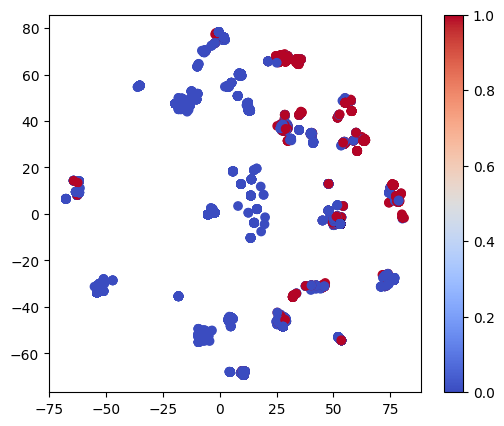

In [6]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

plt.figure(figsize=(6, 5), dpi=100)
tsne_results = TSNE(n_components=2,init='pca',verbose=1,metric='euclidean', perplexity=50).fit_transform(X)
# Plot a scatter plot from the generated t-SNE results
colormap = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1], c = y, cmap=colormap)
plt.colorbar(scatter_plot)
plt.show()

Here we observe several clusters in the feature space, as the most (and the bigest) of them are negative ("0", "not-match", blue). We could conclude 2 things:
- The dataset is probably imbalanced (the common sense also say this, because we have only 1 match among several proposed transactions)
- The positive clusters are always "poluted" with negative samples, although the opposite is not true. So the positive separation probably will be poluted with negative samples... Fortunately that is not contradicting with our ultimate goal as to the user are always presented several transaction choices (up to 4-5-6-7 I suppose) for every receipt.

Let's check the amount of imbalance in the dataset:

In [7]:
print(np.sum(y), len(y), 1.0 / (np.sum(y) / len(y)))

857 12034 14.04200700116686


Imbalance ration is **14:1**. This is > 10:1 (commonly used criteria) so we consider the dataset as **imbalanced**.

Having in mind the imbalancity and our ultimate goal, when we train and evaluate models, the better metrics will be **recall** TP/(TP+FN) (meaning "how less real positives are lost in the battle"), **balanced accuracy** (giving impression how successfully we fight the FP, also well suited for imbalanced datasets) and **f1** (giving a balance between accuracy and recall WHEN the number of TN is high), instead of just accuracy.

Let's now visualice both the correlations between independent variables (X) and between them AND the dependent variable (y):

Text(0.5, 1.0, 'Correlation Heatmap')

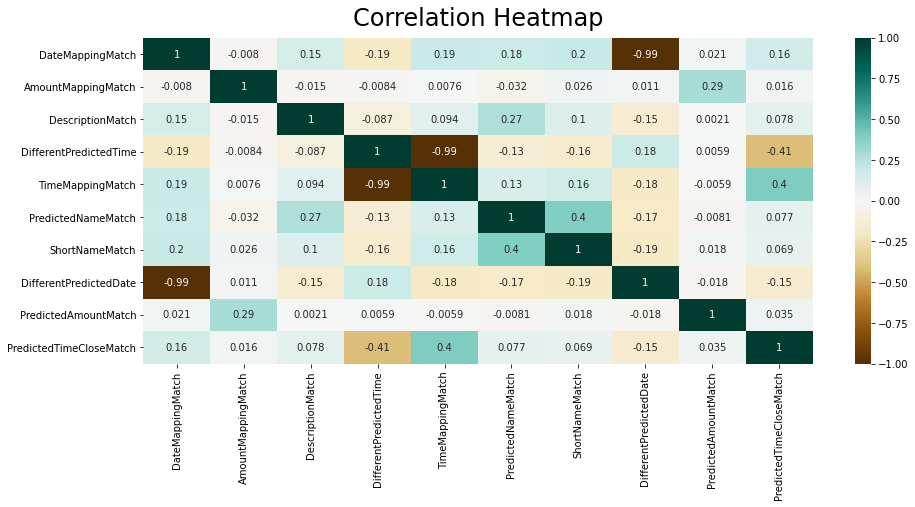

In [8]:
import seaborn as sns

plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(X_pd.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':24}, pad=12)

We notice a strong (negative) correlation between **DifferentPredictedDate** and **DateMappingMatch**. That suggest that one of these 2 features could be ommited during the feature seection.
The similar is the case with **DifferentPredictedTime** and **TimeMappingMatch**.

Text(0.5, 1.0, 'Features Correlating with Dependent variable')

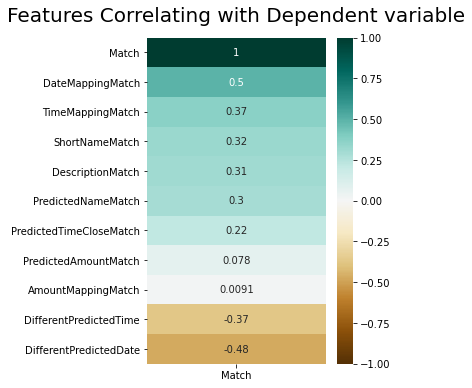

In [9]:
df_new = X_pd.copy()
df_new['Match'] = y

plt.figure(figsize=(4, 6))
heatmap = sns.heatmap(df_new.corr()[['Match']].sort_values(by='Match', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Dependent variable', fontdict={'fontsize':20}, pad=16)

As we supposed in (2.1.), the **"Amount"** features have the lowest correlations with the dependent variable (y).
**AmountMappingMatch** (CC = 0.0091) has insignificat correlations with both the dependent variable as well as the independent variables (its strongest correlation is with the other almost useless feature - PredictedAmountMatch) and could be easily ommited in further considerations.

Another method-independent way to investigate the variable correlations is Spearman’s Rank-Order Correlation:

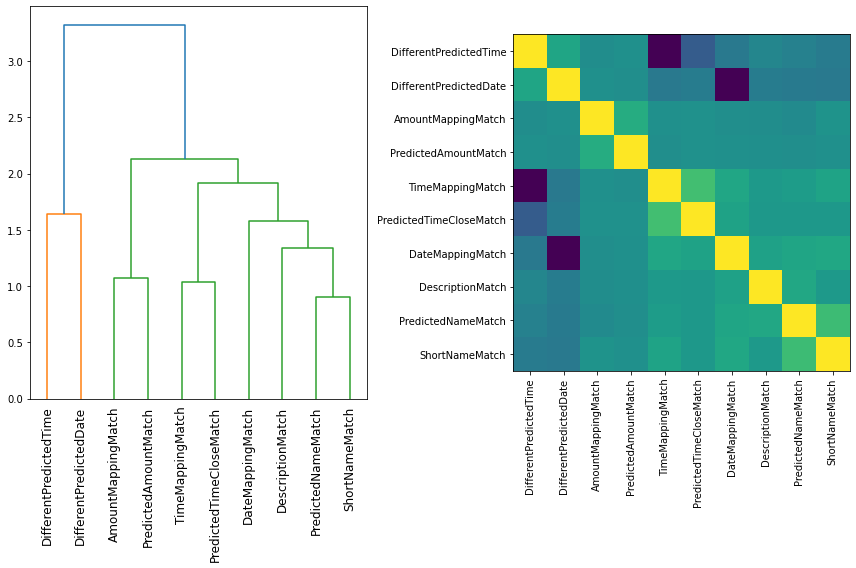

In [10]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=X_pd.columns.tolist(), ax=ax1, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']], cmap='viridis')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()

plt.show()

Let's see what will tell us *the good old* **Logistic regression** regarding the feature importance and their statistical significance:

In [11]:
import statsmodels.api as sm

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.107609
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                12034
Model:                          Logit   Df Residuals:                    12024
Method:                           MLE   Df Model:                            9
Date:                Tue, 01 Jun 2021   Pseudo R-squ.:                  0.5809
Time:                        21:53:22   Log-Likelihood:                -1295.0
converged:                       True   LL-Null:                       -3090.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             5.8764      0.680      8.644      0.000       4.544       7.209
x2            -0.7736      0

(*Here I use statsmodel.api because sklearn's LogisticRegression in its latest versions automatically uses regularization whitch have to be tricked with the C-parameter...*)<br>The greatest P-values (> 0.05) have x2 and x8 (AmountMappingMatch and DifferentPredictedDate) both supporting the above considerations.<br>The biggest surprise here is x9 (PredictedAmountMatch) which seems both significant and with a high impact... This is probably due to the fact that many negative feature vectors are indistinguishable from positives and have this feature intact...

## 4. Models training and selection

Let's see what will give us as a result the Logistig regression if we use it as our test model:

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=13)
X_train.shape, y_train.shape

((8062, 10), (8062,))

In [14]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix

In [16]:
def show_metrics(y_test, y_pred):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, y_pred)
    print('F1 score: %f' % f1)
    mtx = confusion_matrix(y_test, y_pred)
    # balanced_accuracy: ( tp/(tp+fn) + tn/(tn+fp) ) / 2
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print('Balanced accuracy: %f' % balanced_accuracy)

    matrix = confusion_matrix(y_test, y_pred)
    print('Confusion matrix:\n', matrix)

In [17]:
show_metrics(y_test, y_pred)

Accuracy: 0.957956
Precision: 0.848101
Recall: 0.483755
F1 score: 0.616092
Balanced accuracy: 0.738630
Confusion matrix:
 [[3671   24]
 [ 143  134]]


Rather discouraging... Our first model misses about half of the positive vectors (the recall is rather poor)...<br>

But **we could use one trick** in order to improve that!<br>
Insted of a binary value at the exit of the model, we could use the (it's native) probability output via the **predict_proba** metod, consecuently thresholding it!<br>
When we lower the threshold (down from its "native" value of 0.5), this will have an effect to count more FNs as TPs (as well as, unfortunately, to count more TNs as FPs...):

In [18]:
for i in range(9):
    thresh = (i+1) / 10.0
    y_pred = np.where(model.predict_proba(X_test)[:,1] > thresh, 1, 0)
    matrix = confusion_matrix(y_test, y_pred)
    print('TSH: %f' % thresh)
    show_metrics(y_test, y_pred)
    print(" ")

TSH: 0.100000
Accuracy: 0.845921
Precision: 0.311161
Recall: 0.996390
F1 score: 0.474227
Balanced accuracy: 0.915516
Confusion matrix:
 [[3084  611]
 [   1  276]]
 
TSH: 0.200000
Accuracy: 0.947130
Precision: 0.612795
Recall: 0.657040
F1 score: 0.634146
Balanced accuracy: 0.812958
Confusion matrix:
 [[3580  115]
 [  95  182]]
 
TSH: 0.300000
Accuracy: 0.958459
Precision: 0.766667
Recall: 0.581227
F1 score: 0.661191
Balanced accuracy: 0.783983
Confusion matrix:
 [[3646   49]
 [ 116  161]]
 
TSH: 0.400000
Accuracy: 0.961732
Precision: 0.830688
Recall: 0.566787
F1 score: 0.673820
Balanced accuracy: 0.779063
Confusion matrix:
 [[3663   32]
 [ 120  157]]
 
TSH: 0.500000
Accuracy: 0.957956
Precision: 0.848101
Recall: 0.483755
F1 score: 0.616092
Balanced accuracy: 0.738630
Confusion matrix:
 [[3671   24]
 [ 143  134]]
 
TSH: 0.600000
Accuracy: 0.951662
Precision: 0.857143
Recall: 0.368231
F1 score: 0.515152
Balanced accuracy: 0.681815
Confusion matrix:
 [[3678   17]
 [ 175  102]]
 
TSH: 0.700

We see that for small values of the threshold (0.1) our model leaves only 2 FNs!
Let's play a little around this (0.1) treshold value:

In [19]:
for i in range(9):
    thresh = (i+1) / 100.0 + 0.05
    y_pred = np.where(model.predict_proba(X_test)[:,1] > thresh, 1, 0)
    matrix = confusion_matrix(y_test, y_pred)
    print('TSH: %f' % thresh)
    show_metrics(y_test, y_pred)
    print(" ")

TSH: 0.060000
Accuracy: 0.841893
Precision: 0.305648
Recall: 0.996390
F1 score: 0.467797
Balanced accuracy: 0.913351
Confusion matrix:
 [[3068  627]
 [   1  276]]
 
TSH: 0.070000
Accuracy: 0.842397
Precision: 0.306326
Recall: 0.996390
F1 score: 0.468591
Balanced accuracy: 0.913621
Confusion matrix:
 [[3070  625]
 [   1  276]]
 
TSH: 0.080000
Accuracy: 0.842649
Precision: 0.306667
Recall: 0.996390
F1 score: 0.468989
Balanced accuracy: 0.913757
Confusion matrix:
 [[3071  624]
 [   1  276]]
 
TSH: 0.090000
Accuracy: 0.845670
Precision: 0.310811
Recall: 0.996390
F1 score: 0.473820
Balanced accuracy: 0.915380
Confusion matrix:
 [[3083  612]
 [   1  276]]
 
TSH: 0.100000
Accuracy: 0.845921
Precision: 0.311161
Recall: 0.996390
F1 score: 0.474227
Balanced accuracy: 0.915516
Confusion matrix:
 [[3084  611]
 [   1  276]]
 
TSH: 0.110000
Accuracy: 0.845921
Precision: 0.311161
Recall: 0.996390
F1 score: 0.474227
Balanced accuracy: 0.915516
Confusion matrix:
 [[3084  611]
 [   1  276]]
 
TSH: 0.120

From threshold = 0.06 up to threshold = 0.11 the FP count decreases, both without sacrificing the recall and with increasing the balanced accuracy and F1 score.<br>
That rather good!

Now let's try the simplest clustering method KMeans with only 2 clusters (with no thresho;ding or parameter tuning):

In [47]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2, n_init = 10, random_state=100)
model.fit(X_train)
y_pred = model.predict(X_test)

In [48]:
show_metrics(y_test, y_pred)

Accuracy: 0.819990
Precision: 0.278788
Recall: 0.996390
F1 score: 0.435675
Balanced accuracy: 0.901578
Confusion matrix:
 [[2981  714]
 [   1  276]]


It performs impressive just Out-Of-the-Box!<br>
Unfortunately - it doesn't support probabilistic output (**predict_proba** metod) and conldn't be used for likelihood evaluations.

But, hey, we live in 2021! There are **a lot of new methods** with both increased classification power and optimized for computational eficiency, memory/cache usage, multithreading etc...<br>
We could choose between classical Logistic regression, SVMs, clustering methods, ensemble methods, decision tree-based methods, including today's King - e**X**treme **G**radient **B**oosting (XGBoost).<br>
Let's score some of them (via 5-fold Cross-Validation):

In [22]:
# Import models
from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from xgboost                 import XGBClassifier

from sklearn.model_selection import cross_val_score

In [23]:
# Scoring methods based on balanced_accuracy metric
bacc_LogitReg   = cross_val_score(LogisticRegression()    , X, y, scoring='balanced_accuracy', cv=5)
bacc_DecTree    = cross_val_score(DecisionTreeClassifier(), X, y, scoring='balanced_accuracy', cv=5)
bacc_RndFrst    = cross_val_score(RandomForestClassifier(), X, y, scoring='balanced_accuracy', cv=5)
bacc_XGB        = cross_val_score(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), X, y, \
                                  scoring='balanced_accuracy', cv=5)
# balanced_accuracy recall
recall_LogitReg = cross_val_score(LogisticRegression()    , X, y, scoring='recall', cv=5)
recall_DecTree  = cross_val_score(DecisionTreeClassifier(), X, y, scoring='recall', cv=5)
recall_RndFrst  = cross_val_score(RandomForestClassifier(), X, y, scoring='recall', cv=5)
recall_XGB      = cross_val_score(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), X, y, \
                                  scoring='recall', cv=5)

In [24]:
bacc_LogitReg.mean(), bacc_DecTree.mean(), bacc_RndFrst.mean(), bacc_XGB.mean()

(0.7456926416865381,
 0.7761175905430134,
 0.7761759331635207,
 0.7807715702032774)

In [25]:
recall_LogitReg.mean(), recall_DecTree.mean(), recall_RndFrst.mean(), recall_XGB.mean()

(0.501047191622467, 0.5603631170950631, 0.5627362981096151, 0.5720998232014143)

The models perform better and better one after another in a good regards with their complexity and the time of arising...<br>
Here, expectedly, **the winner is XGBoost**. It overall performs the best, and despite Kmeans, could be further optimized via tresholing, and also outputs probabilityes.<br>
Let's se how it performs with tresholding:

In [26]:
XGB_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=13)
XGB_model.fit(X_train, y_train)
y_pred = XGB_model.predict(X_test)

In [27]:
for i in range(9):
    thresh = (i+1) / 100.0
    y_pred = np.where(XGB_model.predict_proba(X_test)[:,1] > thresh, 1, 0)
    matrix = confusion_matrix(y_test, y_pred)
    print('TSH: %f' % thresh)
    show_metrics(y_test, y_pred)
    print(" ")

TSH: 0.010000
Accuracy: 0.833837
Precision: 0.295624
Recall: 1.000000
F1 score: 0.456343
Balanced accuracy: 0.910690
Confusion matrix:
 [[3035  660]
 [   0  277]]
 
TSH: 0.020000
Accuracy: 0.841641
Precision: 0.305310
Recall: 0.996390
F1 score: 0.467401
Balanced accuracy: 0.913215
Confusion matrix:
 [[3067  628]
 [   1  276]]
 
TSH: 0.030000
Accuracy: 0.844411
Precision: 0.309071
Recall: 0.996390
F1 score: 0.471795
Balanced accuracy: 0.914704
Confusion matrix:
 [[3078  617]
 [   1  276]]
 
TSH: 0.040000
Accuracy: 0.848691
Precision: 0.315068
Recall: 0.996390
F1 score: 0.478751
Balanced accuracy: 0.917004
Confusion matrix:
 [[3095  600]
 [   1  276]]
 
TSH: 0.050000
Accuracy: 0.850705
Precision: 0.317552
Recall: 0.992780
F1 score: 0.481190
Balanced accuracy: 0.916417
Confusion matrix:
 [[3104  591]
 [   2  275]]
 
TSH: 0.060000
Accuracy: 0.850705
Precision: 0.317552
Recall: 0.992780
F1 score: 0.481190
Balanced accuracy: 0.916417
Confusion matrix:
 [[3104  591]
 [   2  275]]
 
TSH: 0.070

That is an amazing performance! In the threshold interva 0.01 - 0.07 XGBoost has a Recall near 1 and Balanced accuracy up to 91%.

And one last try: SVM with sigmoid kernel (rather near to the Logistic regression):

In [28]:
from sklearn.svm import SVC

SVM_model = SVC(kernel = 'sigmoid', probability=True, random_state=100)
SVM_model.fit(X_train, y_train)
y_pred = SVM_model.predict(X_test)

In [29]:
show_metrics(y_test, y_pred)

Accuracy: 0.946878
Precision: 0.775000
Recall: 0.335740
F1 score: 0.468514
Balanced accuracy: 0.664216
Confusion matrix:
 [[3668   27]
 [ 184   93]]


In [30]:
for i in range(9):
    thresh = (i+1) / 100.0 + 0.05
    y_pred = np.where(SVM_model.predict_proba(X_test)[:,1] > thresh, 1, 0)
    matrix = confusion_matrix(y_test, y_pred)
    print('TSH: %f' % thresh)
    show_metrics(y_test, y_pred)
    print(" ")

TSH: 0.060000
Accuracy: 0.815458
Precision: 0.274257
Recall: 1.000000
F1 score: 0.430458
Balanced accuracy: 0.900812
Confusion matrix:
 [[2962  733]
 [   0  277]]
 
TSH: 0.070000
Accuracy: 0.817472
Precision: 0.276447
Recall: 1.000000
F1 score: 0.433151
Balanced accuracy: 0.901894
Confusion matrix:
 [[2970  725]
 [   0  277]]
 
TSH: 0.080000
Accuracy: 0.830816
Precision: 0.291886
Recall: 1.000000
F1 score: 0.451876
Balanced accuracy: 0.909066
Confusion matrix:
 [[3023  672]
 [   0  277]]
 
TSH: 0.090000
Accuracy: 0.830816
Precision: 0.291886
Recall: 1.000000
F1 score: 0.451876
Balanced accuracy: 0.909066
Confusion matrix:
 [[3023  672]
 [   0  277]]
 
TSH: 0.100000
Accuracy: 0.830564
Precision: 0.290254
Recall: 0.989170
F1 score: 0.448812
Balanced accuracy: 0.903922
Confusion matrix:
 [[3025  670]
 [   3  274]]
 
TSH: 0.110000
Accuracy: 0.829305
Precision: 0.281828
Recall: 0.935018
F1 score: 0.433110
Balanced accuracy: 0.878199
Confusion matrix:
 [[3035  660]
 [  18  259]]
 
TSH: 0.120

Up to a threshold of 0.08 this method gives 0 /zero/ FNs!<br>
(although it gives much more FPs than XGBoost)

Let's see the feature importance from the viewpoint of the decision tree-based methods:

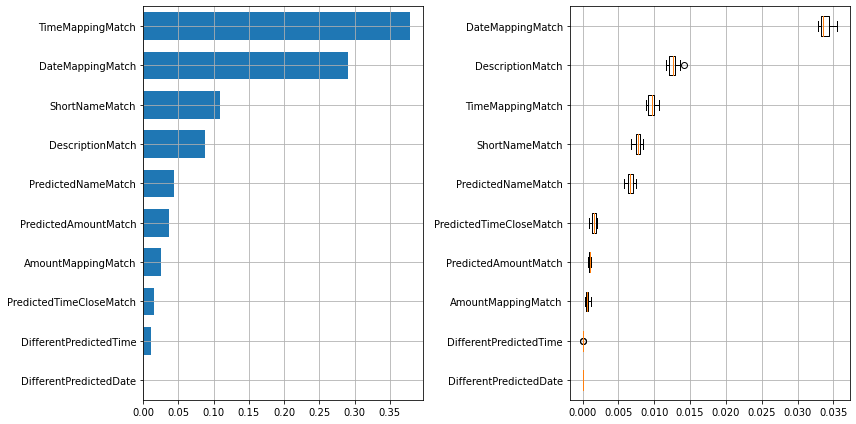

In [31]:
from sklearn.inspection import permutation_importance

model = XGB_model

result = permutation_importance(model, X, y, n_repeats=10,
                                random_state=13)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(model.feature_importances_)
tree_indices = np.arange(0, len(model.feature_importances_)) + 0.5

plt.rcParams["axes.grid"] = True
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.barh(tree_indices, model.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X_pd.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(model.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False, \
            labels=X_pd.columns[perm_sorted_idx])
fig.tight_layout()
plt.show()

Here we could run i.e. 1000 train-test splits with different random seeds and Cross Validation and to average the results in order to be pretty sure about the true performance of the methods, but the SVC(sigmoid kernel) with treshold 0.08 and XGBoost with treshold 0.01 - 0.04 are the best so far.<br>
The ratio between FP and TP varies from 2.23:1 to 2.77:1 (with negligible or no loss ot TPs), which is **rather acceptable** from the user perspective to have **3-4 transactions to compare for every receipt**.<br>
Moreover **the probability output** of the classifier could be used as a likelihood metrics for comparison and sorting the resulting vectors for the user.

In [32]:
receipts = data['receipt_id'].unique()

In [33]:
len(receipts)

1155

## 5. Putting all together

Let's collect the data for the different receipts in a better structured list - fs

In [34]:
# Collect the data for the different receipts in a better structured list fs

fs=[]

i = 0
for index, j in data.iterrows():
    
    if i == 0 and index == 0:
        rec=[]
        rec.append(int(receipts[i]))
        trans=[]
        trans.append(int(data.iloc[index][3]))
        trans.append(y[index])
        trans.append(list(data.iloc[index][4:]))
        rec.append(trans)
        continue
    
    if data.iloc[index][0] == receipts[i]:
        trans=[]
        trans.append(int(data.iloc[index][3]))
        trans.append(y[index])
        trans.append(list(data.iloc[index][4:]))
        rec.append(trans)

    else:
        i = i + 1
        fs.append(rec)
        if i == len(data):
            break
        rec=[]
        rec.append(int(receipts[i]))
        trans=[]
        trans.append(int(data.iloc[index][3]))
        trans.append(y[index])
        trans.append(list(data.iloc[index][4:]))
        rec.append(trans)

In [35]:
fs

[[10000,
  [10000, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [10001, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [10003, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [10004, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [10005, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [10006, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [10008, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [10009, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [10010, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [10011, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [10016, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [10019, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [10020, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [10021, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [10022, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
 

Let's now filter-out the receipts, for which the "success" is not possible<br>(these which haven't match between *matched_transaction_id* and *feature_transaction_id*)

In [36]:
fs_filt = []

for receipt in fs:
    tmp = 0
    for trans in receipt[1:]:
        #print(trans[1])
        tmp = tmp + trans[1]
    if tmp == 1:
        #print(receipt[0])
        fs_filt.append(receipt)

In [37]:
len(fs), len(fs_filt)

(1154, 856)

Here 856 out of 1154 receipts have a match-vector.

In [38]:
from random import sample

fs_filt_shuff = sample(fs_filt, len(fs_filt))

In [39]:
fs_filt_shuff

[[20211,
  [20349, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [20351, 1, [0.95, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]],
 [30143,
  [30012, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [31183, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [31185, 0, [0.0, 0.4, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [31190, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]],
  [31195, 1, [0.95, 0.7, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0]]],
 [50064,
  [50102, 1, [0.95, 0.4, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
  [50204, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]],
  [50205, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [50206, 0, [0.0, 0.4, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]]],
 [50186,
  [50029, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]],
  [50030, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [50031, 0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
  [50288, 0, [0.0, 0.0, 0.0, 1.0, 

Let's now check in how many of the receipts there is duplicates of the matching feature-vector?

In [40]:
def try_vector_matching(a, b):
    tmp = 0.0
    for i in range(len(a)):
        tmp = tmp + abs(a[i] - b[i])
    #print(tmp)
    if tmp == 0.0:
        return 1
    else:
        return 0

In [41]:
for receipt in fs_filt:
    for i,trans in enumerate(receipt[1:]):
        if trans[1] == 1:
            pos = i            
            break
    #print(receipt[0], pos)        
    #pos = index(1, )
    count = 0
    for i,trans in enumerate(receipt[1:]):
        if i != pos:
            tmp = try_vector_matching(trans[2], receipt[1+pos][2])
            if tmp == 1:
                count = count + 1
    print(receipt[0], pos, count)

10001 5 1
10002 0 0
10003 4 1
10005 11 7
10007 8 1
10009 11 0
10010 9 1
10011 16 0
10012 2 2
10014 6 0
10015 2 0
10017 0 0
10018 10 1
10019 9 0
10020 6 0
10021 3 0
10022 8 0
10023 1 2
10024 12 1
10025 0 0
10026 4 3
10028 11 3
10029 2 0
10030 4 0
10031 13 4
10032 8 2
10033 0 0
10034 8 1
10035 4 0
10036 1 0
10037 2 1
10039 13 6
10040 9 1
10041 3 0
10042 6 5
10043 6 0
10044 8 0
10045 11 5
10046 7 0
10047 2 5
10048 3 0
10049 3 0
10051 1 0
10052 7 0
10053 2 3
10054 4 0
10055 7 3
10058 7 5
10059 1 0
10060 2 0
10061 1 0
10062 10 5
10064 3 3
10065 2 1
10066 3 2
10067 4 0
10068 1 0
10070 6 2
10071 1 0
10072 3 0
10075 12 1
10076 1 0
10077 17 0
10079 9 6
10080 1 0
10083 1 0
10085 6 0
10086 0 0
10087 12 6
10088 5 0
10089 1 3
10090 12 7
10091 12 0
10092 4 0
10093 7 3
10094 2 2
10096 2 0
10098 5 0
10100 10 0
10101 1 0
10103 6 3
10104 8 0
10105 11 1
10106 2 0
10108 9 6
10109 3 1
10111 5 1
10114 11 6
10115 9 1
10116 4 4
10117 11 5
10118 12 1
10119 13 8
10121 12 0
10122 3 6
10124 5 2
10127 4 0
10129 4 

A quick inspection shows that, for example - for receipt #40018, we have **up to 10 /ten!/ duplicates** of the matching feature-vector!

In such a case, one (*may be ridiculous*) idea is **to investigate the position probability of the matching vector among the duplicates**, sorted by transaction number. It will also depends of the number of duplicates...<br>
For example: if we have 1 duplicate vector in the receipt, the position of the true matching vector could be 1 or 2. If we make histogram, from the provided data, how many matching vectors are on the 1st and on the 2nd position, afterwards we could guess, that when we have 2 duplicating best candidates (sugested by our ML-model), it will be on the dominant position (1 or 2) with better probability than the other...<br>*That will increase much the chance to hit the real matching vector among the duplicates, than by a random guess...*

In [42]:
stats_table = np.zeros((12,10), dtype=('int'))

for receipt in fs_filt:
    # Obtain the position of the real feature-matching vector
    for i,trans in enumerate(receipt[1:]):
        if trans[1] == 1:
            pos = i            
            break

    # Extract a list of all the duplicates, including the matching vector
    dup_list = []
    for trans in receipt[1:]:
        tmp = try_vector_matching(trans[2], receipt[1+pos][2])
        if tmp == 1:
            dup_list.append(trans)
    
    # Sorting the set of duplicates by transaction_id descendingly
    dup_list = sorted(dup_list, key = lambda x: int(x[0])) #, reverse = True)
    
    # Obtain again the position real feature-matching vector and update the statistics (in stats_table)
    for i,trans in enumerate(dup_list):
        if trans[1] == 1:
            pos = i            
            break
            
    stats_table[len(dup_list)][pos] = stats_table[len(dup_list)][pos] + 1
    
print("Stats table:\n", stats_table[1:])


Stats table:
 [[594   0   0   0   0   0   0   0   0   0]
 [ 60  51   0   0   0   0   0   0   0   0]
 [ 17  28  17   0   0   0   0   0   0   0]
 [ 11  10   9   6   0   0   0   0   0   0]
 [  4   6   4   3   3   0   0   0   0   0]
 [  5   5   1   1   2   0   0   0   0   0]
 [  2   2   1   2   4   1   0   0   0   0]
 [  0   0   0   1   0   1   1   0   0   0]
 [  1   0   0   1   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0]]


It's seems that when we have 2 candidate vectors (one match and one duplicate) there is a slight tendency the first position (60) to be prefered over the second (51). This is 54:46 chance over the 50:50 by random.<br>
- For 3 candidate-vectors the dominace of the 2nd position is even bigger 28:45:28 instead of 33:33:33 by chance.<br>
- For 5 and more candidate-vectors the amount of data is too low in order to have any statistical significance...<br>
<br>Overall: 1st and 2nd postions seems to be preferable! Probably just a simple sorting of the candidate vectors by transaction_id and taking the first of them will give us good enough result.

In [43]:
position_table = np.zeros(stats_table.shape[0], dtype=('int'))

for i in range(stats_table.shape[0]):
    m = max(stats_table[i])
    pos = [j for j, k in enumerate(stats_table[i]) if k == m][0]
    position_table[i] = pos
print(position_table)

[0 0 0 1 0 1 0 4 3 0 0 7]


Let's first **save on disk our XGBoost trained model** in order to use it afterwards in our transaction_predictor function

In [44]:
import pickle

# save the model to disk
filename = 'XGBoost_model.mod'
pickle.dump(XGB_model, open('./models/' + filename, 'wb'))

In [45]:
def transaction_predictor(a, position_optimization=True):
    # Load already trained model on disk
    filename = 'XGBoost_model.mod'
    model = pickle.load(open('./models/' + filename, 'rb'))
    
    # hardcoded position_table
    position_table = [0, 0, 0, 1, 0, 1, 0, 4, 3, 0, 0, 7]
    
    X = np.array(a)
    Z = X[:,1:]

    y = model.predict_proba(Z)[:,1]
    
    new_col = y[...,None]
    #print(new_col.shape)
    
    X = np.append(X,new_col,1)
    #print(X.shape)
    
    X = X[X[:, -1].argsort()][::-1,:]
    
    if position_optimization:
        
        # Checking if there are duplicates of the best candidate vector
        max_proba = X[0][-1] # best candidate
        #print(max_proba)

        # Count the numer of duplicates (in lim)
        lim = 1
        for i in range(1, X.shape[0]):
            if X[i][-1] == max_proba:
                lim = lim + 1
            else:
                break
        #print('lim: ', lim)
        #print(X.shape[0])

        if lim > 1: # if there are duplicates

            # Order the rows of duplicates by the transaction_id
            X = np.append(X[X[:lim, 0].argsort()], X[lim:], 0)

            # Exchange the first duplicated row with the row with the most probable position to hit the real
            # matching vector
            exch = position_table[lim] # it depends of the number of duplicates
            if exch != 0:
                X[[0, exch]] = X[[exch, 0]]
    
    # Output a list of transaction_id's ordered by decreasing probability and the most probable candidate first
    output = list(X[:,0].astype(int))
    return output
    
    np.set_printoptions(suppress=True)
    #print(X)  

In [46]:
# Check the success rate with and without postition optimization

success_pos = 0
success_non_pos = 0

for i, receipt in enumerate(fs_filt_shuff):
    
    trans_set = []
    
    winning_transaction = 0
    
    for j,trans in enumerate(receipt[1:]):
        tmp = []
        tmp.append(trans[0])
        if trans[1] == 1:
            winning_transaction = trans[0]
        for k in trans[2]:
            tmp.append(k)
        #print(tmp)
        trans_set.append(tmp)
    
    #print(trans_set)
    
    # Send it to our naughty function (with default optimization) 
    ordered = transaction_predictor(trans_set)

    if ordered[0] == winning_transaction:
        success_pos = success_pos + 1

    # Send it to our naughty function (without default optimization) 
    ordered = transaction_predictor(trans_set, position_optimization=False)

    if ordered[0] == winning_transaction:
        success_non_pos = success_non_pos + 1


pos     = success_pos     / len(fs_filt_shuff) * 100.0
non_pos = success_non_pos / len(fs_filt_shuff) * 100.0

print('"Success" ratio without position optimization = %.2f%% (%d : %d)' % (non_pos, success_non_pos, len(fs_filt_shuff)))
print('"Success" ratio with position optimization    = %.2f%% (%d : %d)' % (pos, success_pos, len(fs_filt_shuff)))

"Success" ratio without position optimization = 73.48% (629 : 856)
"Success" ratio with position optimization    = 77.45% (663 : 856)


So we managed to **increase the "Success" rate by as much as 4.20%** with the help of our "ridiculous" idea!<br>
True, this statistics is "overfitted" over the whole dataset, but I'm too lasy to make CV... :)

## Advice to the IT staff

**As an advice to the IT staff** I could suggest:<br>
    1. Obviously the matching process between graphical receipt and transaction number includes scanning/OCR-ing receipt images which is not perfect. We cannot control the process/quality of the external supplier, but we could include a **bar-code / QR-code** in the graphic original of the receipt, encoding in that way the vital information as receipt_id, transaction_id, company_id, timestamp, names, descriptions, etc. This is a practically proven way how with almost no additional expenses to improve the quality of reading/decodin vital information drastically and error prone.<br>
    2. If that is not possible/acceptable, please include more numerical information over the (graphical) recipe. Digits are usually much beter recognized by OCR software than letters (especially of different alphabets...).<br>
    3. Add to that digital information (from (2)) one or several additional digit as check-sum or error-correction code. This will improve correctness of the recognized information or at least will give a clear sign wether it is correct or not (and must be discarded).

<img src="./illustrations/qr-code.jpg"><br><br>
Readout of the QR-code: **02558000 \* 0145851 \* 2021-05-05 \* 14:23:00 \* 22.45**

4. There is a discrepancy in you interview-test docimentation! In the description of the data it is mentioned a column with a name "member_id", which in the provided datafile probably corresponds to "company_id". That cost me several sleepless nights to overcome... Due to similar discrepancies and mistakes, your company looses several hundreds of millions of Euro anually! Please take precautions!

<img src="./illustrations/footsteps.jpg">

## Cheers!
<img src="./illustrations/a_cup_of_wine.jpg">